## Deconvolution with Unrolled ADMM

This notebook is a tutorial on deconvolving galaxy images using our pretrained unrolled ADMM model.

In [34]:
import sys
sys.path.append('../')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from models.Unrolled_ADMM import Unrolled_ADMM
from models.Richard_Lucy import Richard_Lucy
from models.Tikhonet import Tikhonov, Tikhonet
from models.Wiener import Wiener
from utils.utils_test import PSNR, estimate_shear

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load data

In [35]:
psf = torch.load("psf.pth")
obs = torch.load("obs.pth")
gt = torch.load("gt.pth")

### Load in pretrained weights

You can choose the number of iterations for the unrolled ADMM model. We provide pretrained weights for iteration number 1,2,4 and 8.

In [36]:
model_path = '../saved_models/'
n_iters = 8
model_file = os.path.join(model_path, f'Gaussian_PnP_ADMM_{n_iters}iters_MultiScale_50epochs.pth')

model = Unrolled_ADMM(n_iters=n_iters, llh='Gaussian')
model.to(device)
model.eval()
model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
print(f'Successfully loaded in {model_file}.')

Successfully loaded in ../saved_models/Gaussian_PnP_ADMM_8iters_MultiScale_50epochs.pth.


### Deconvolution

In [37]:
alpha = torch.Tensor(obs.mean().float()).view(1,1,1,1) # average photon level

output = model(obs.unsqueeze(0).unsqueeze(0).to(device), psf.unsqueeze(0).unsqueeze(0).to(device), alpha.to(device))
rec = (output.cpu() * alpha).squeeze(dim=0).squeeze(dim=0).detach().numpy()
obs, gt = obs.numpy(), gt.numpy()

### Visualization

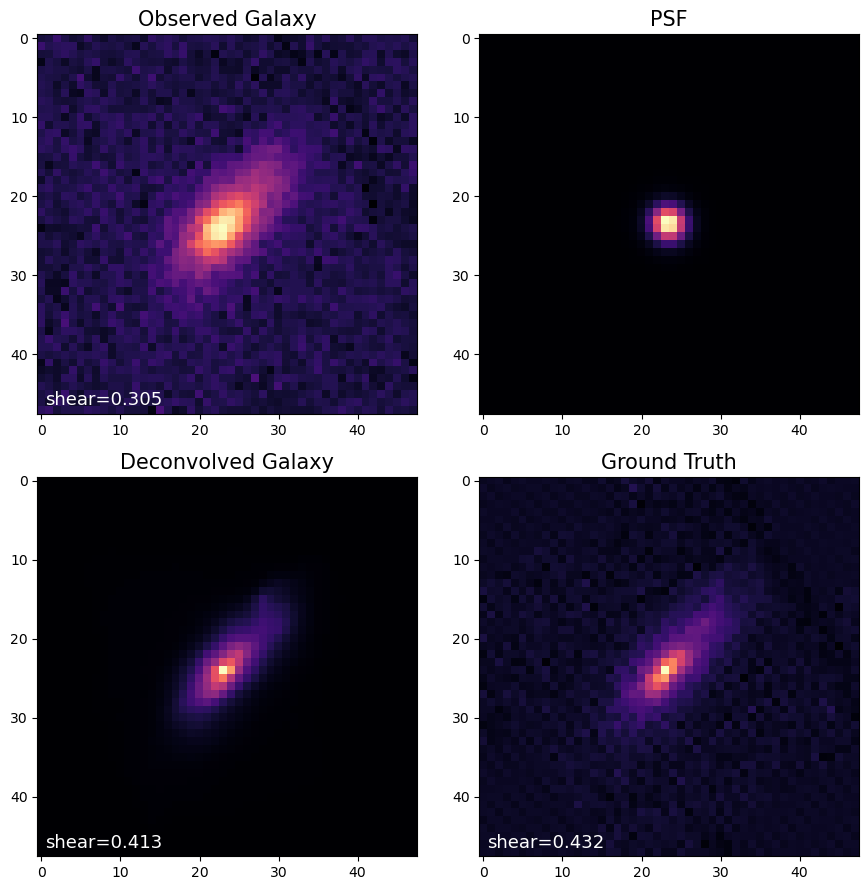

In [38]:
cmap = 'magma'

plt.figure(figsize=(9, 9))
plt.subplot(2,2,1)
plt.imshow(obs, cmap=cmap)
plt.title('Observed Galaxy', fontsize=15)
plt.title('shear={:.3f}'.format(estimate_shear(obs)[2]), loc='left', x=0.02, y=0, fontsize=13, color='white')

plt.subplot(2,2,2)
plt.imshow(psf, cmap=cmap)
plt.title('PSF', fontsize=15)

plt.subplot(2,2,3)
plt.imshow(rec, cmap=cmap)
plt.title('Deconvolved Galaxy', fontsize=15)
plt.title('shear={:.3f}'.format(estimate_shear(rec)[2]), loc='left', x=0.02, y=0, fontsize=13, color='white')

plt.subplot(2,2,4)
plt.imshow(gt, cmap=cmap)
plt.title('Ground Truth', fontsize=15)
plt.title('shear={:.3f}'.format(estimate_shear(gt)[2]), loc='left', x=0.02, y=0, fontsize=13, color='white')

plt.tight_layout()